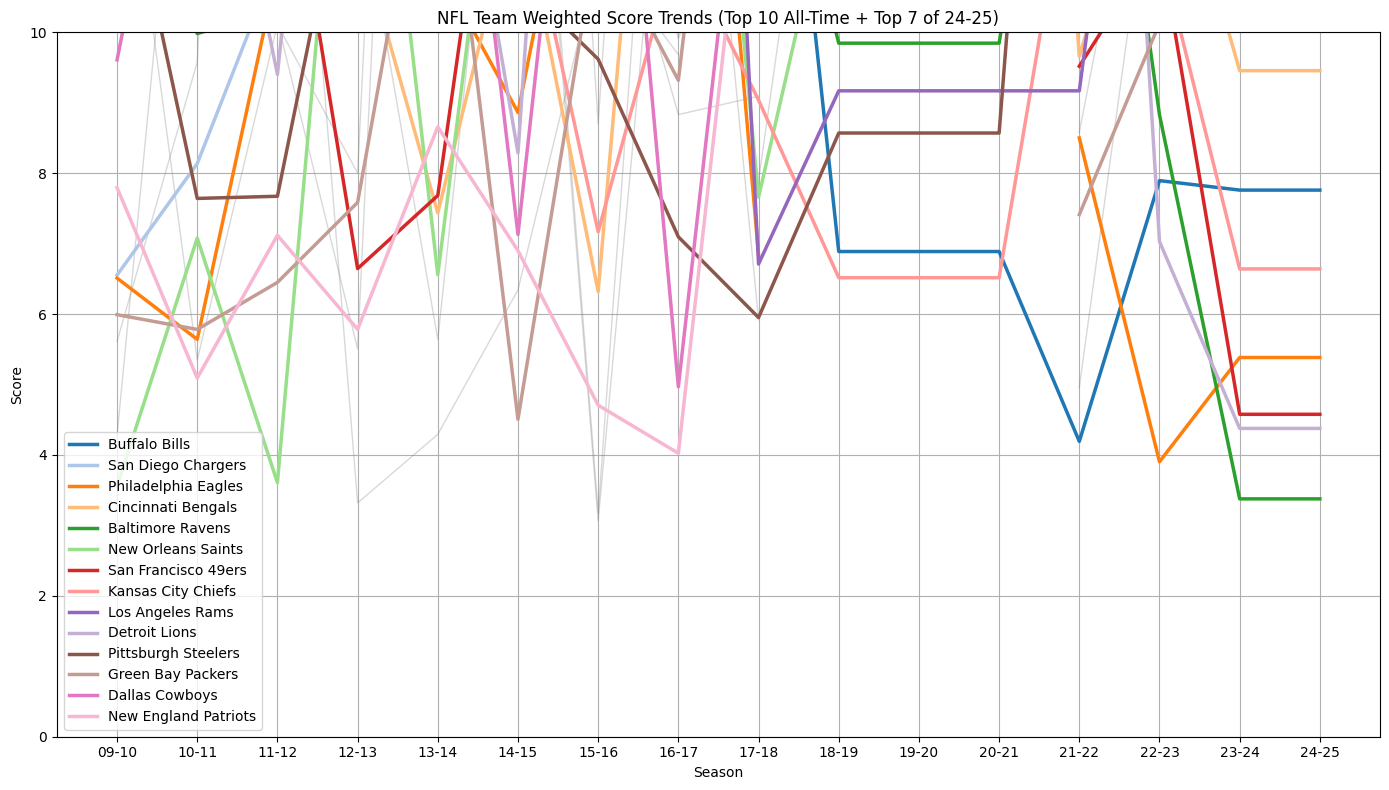

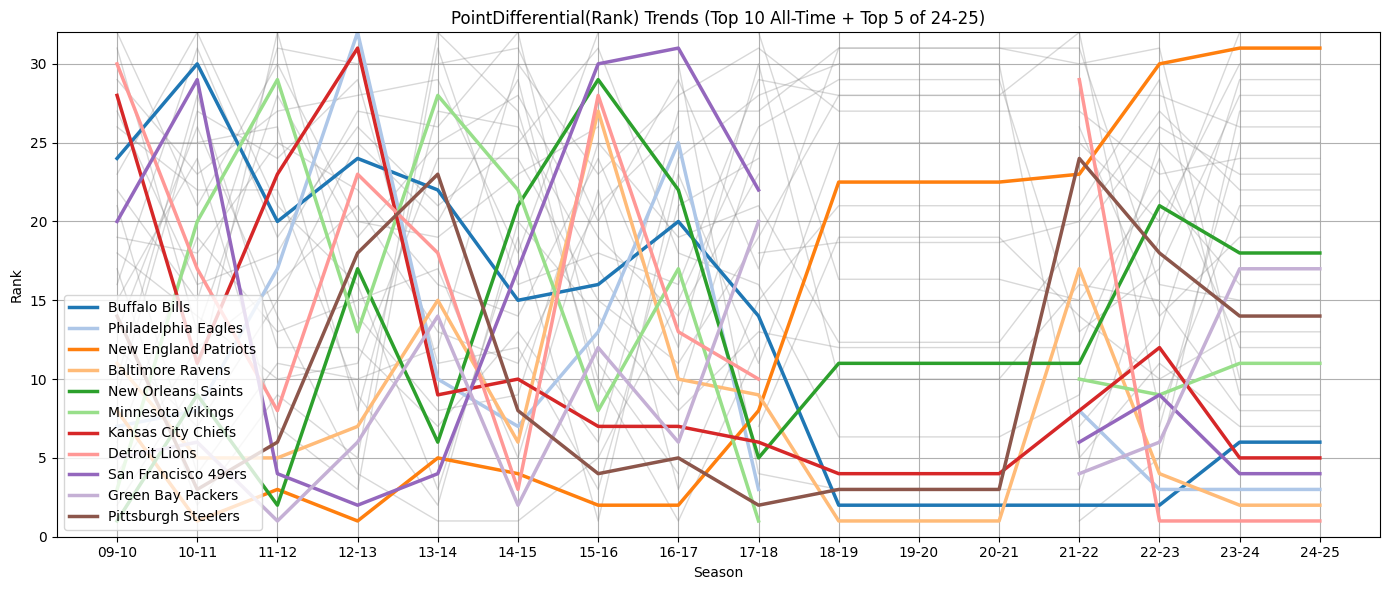

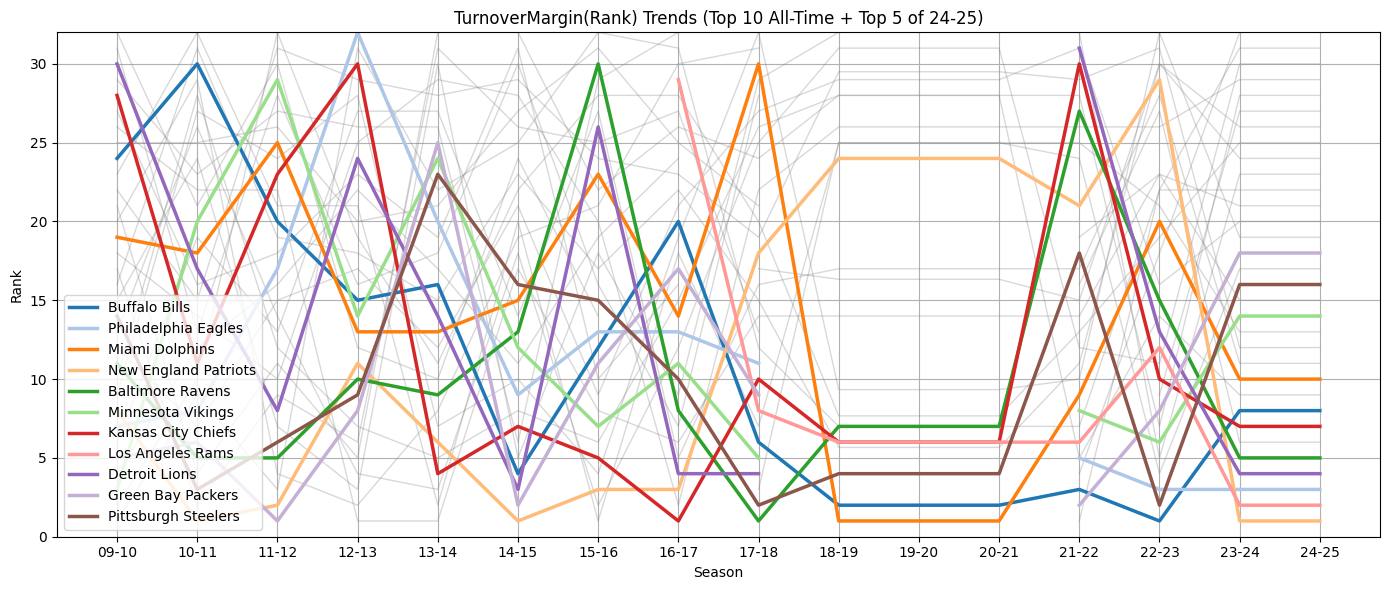

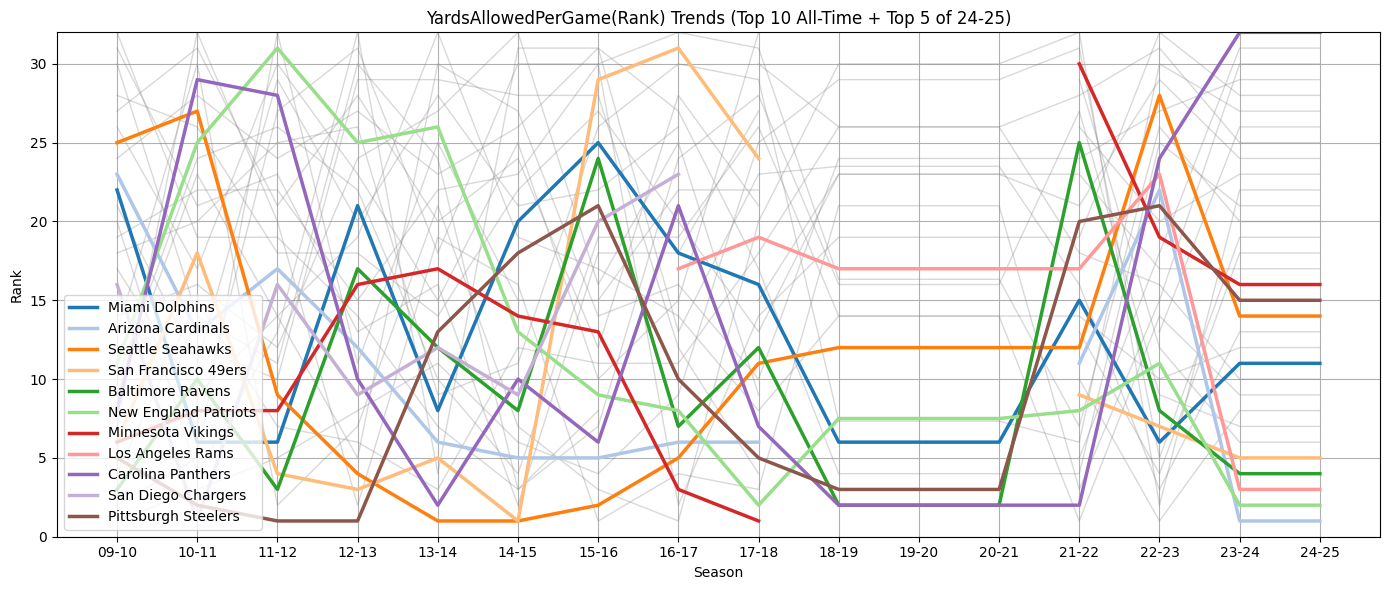

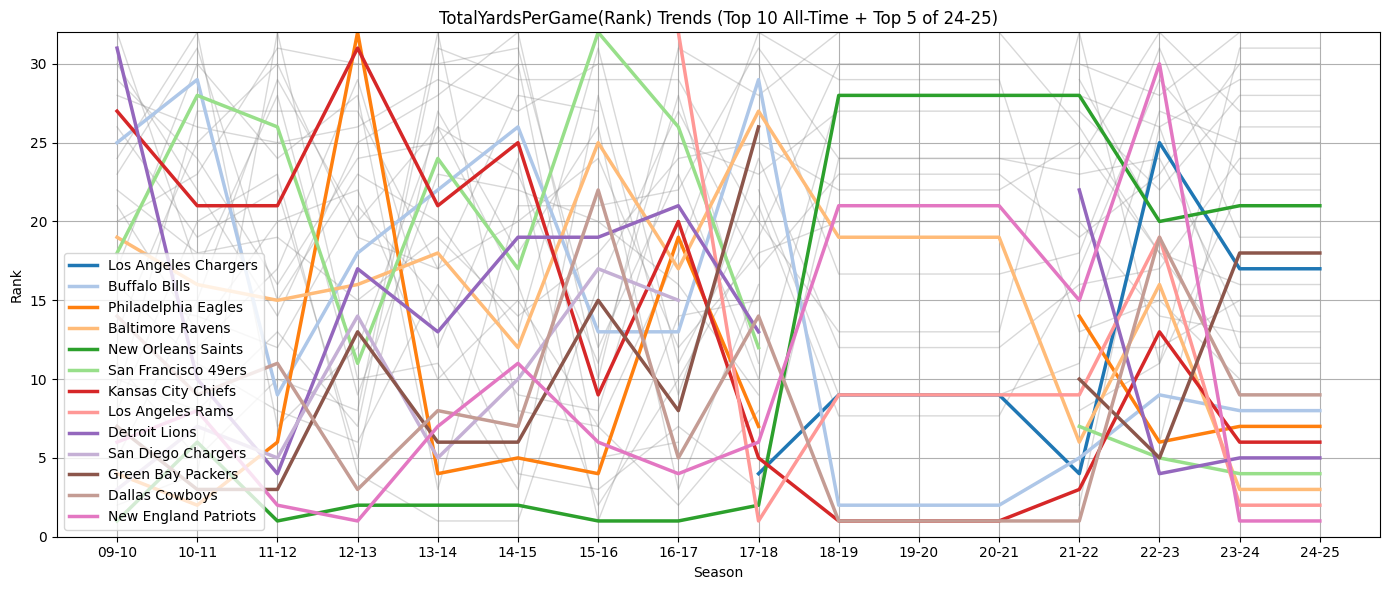

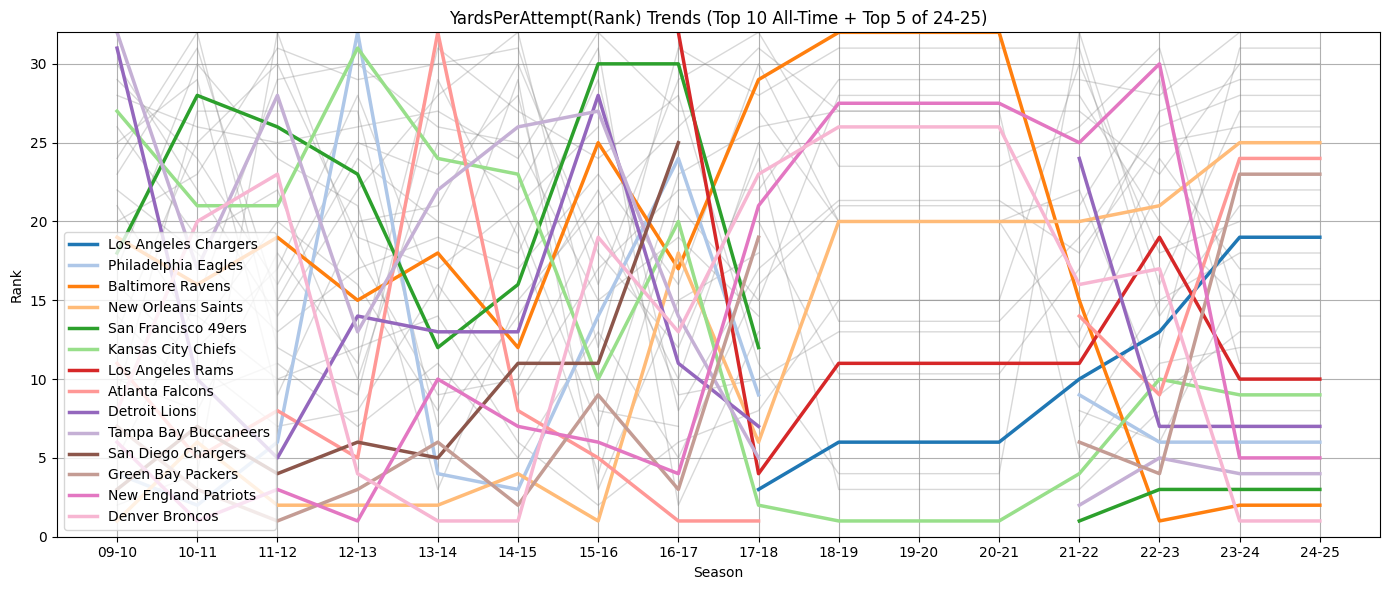

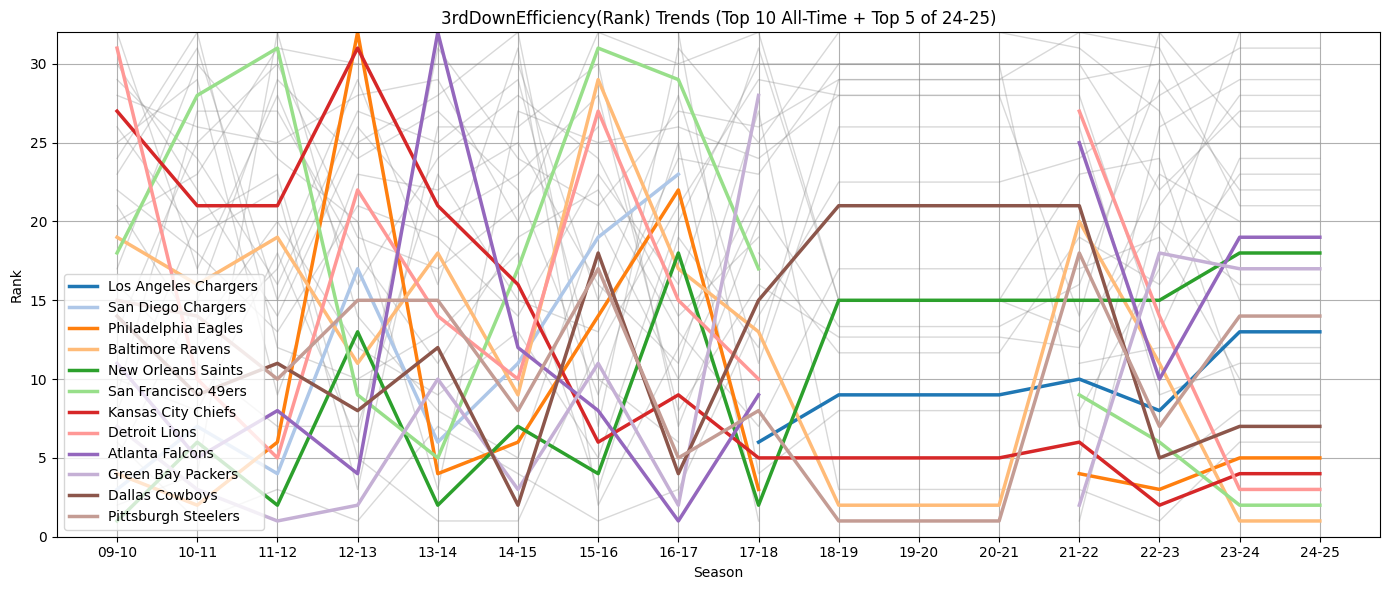

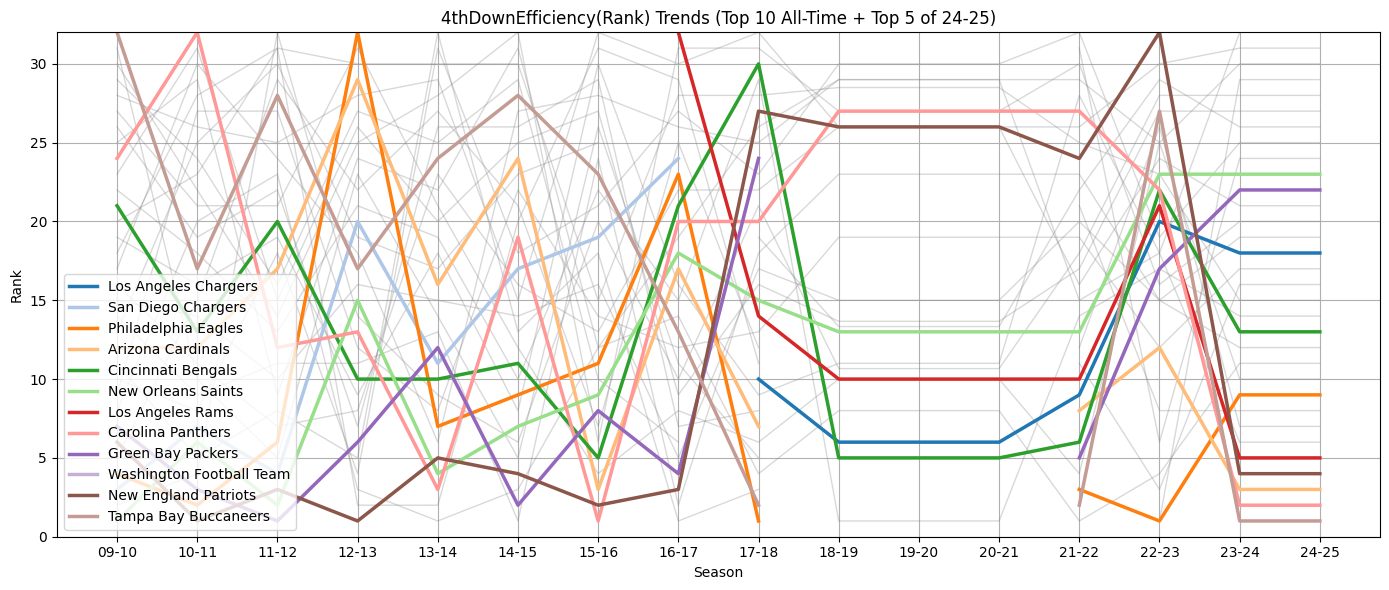

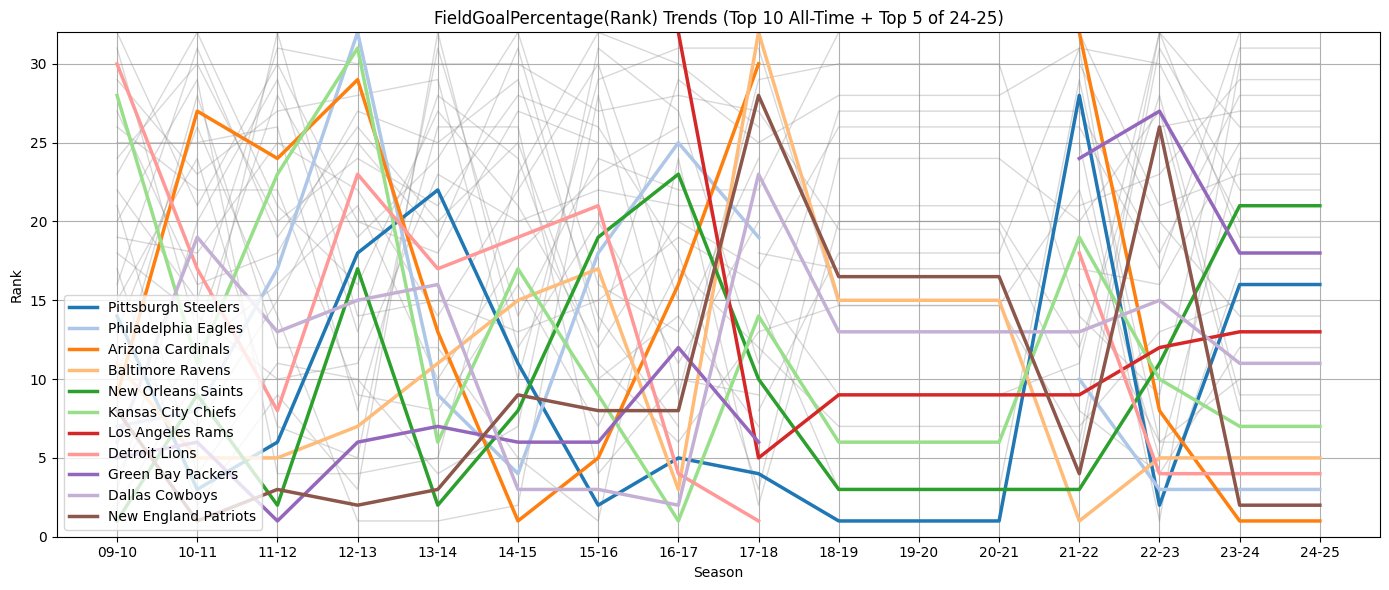

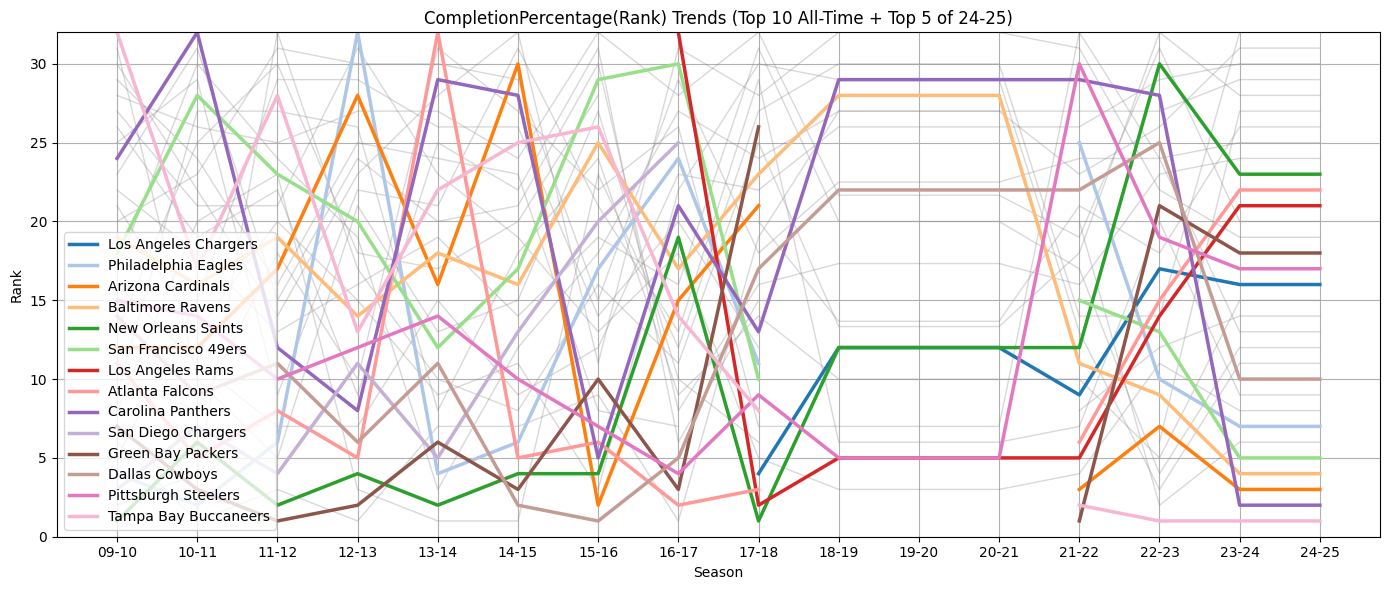

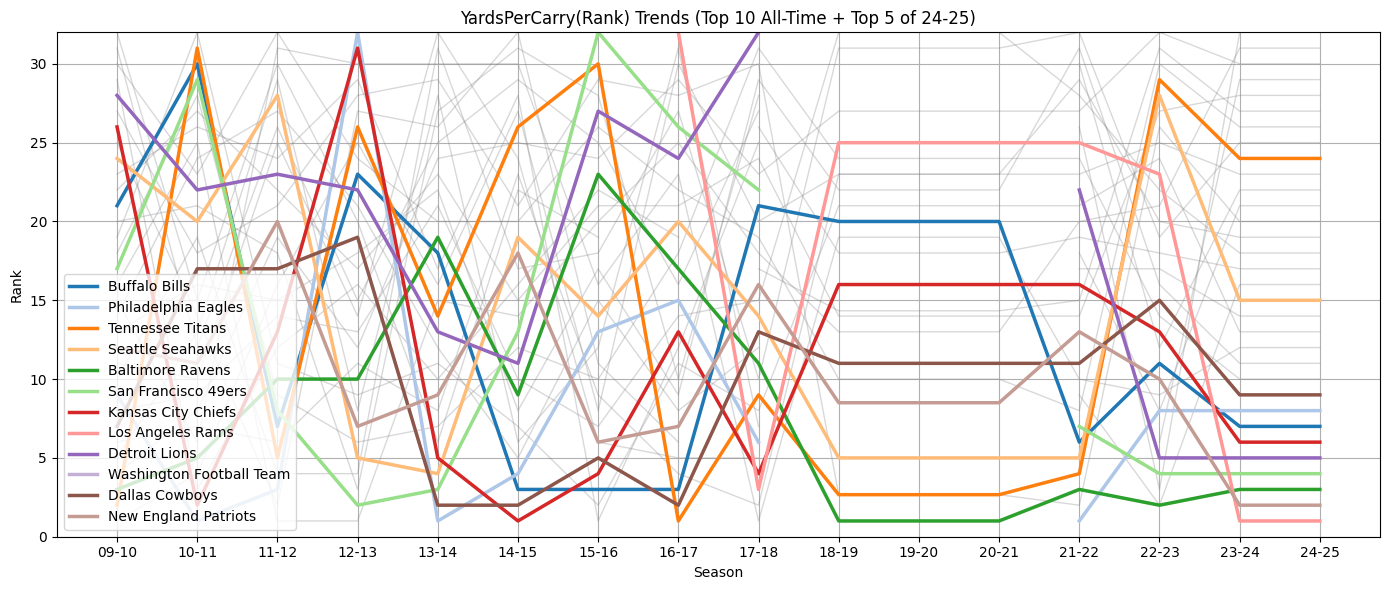

In [7]:
# 📦 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 2. Define Seasons and Weights
seasons = [
    '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16',
    '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23',
    '23-24', '24-25'
]
data_by_year = []

weights = {
    'PointDifferential(Rank)': 0.201375,
    'TurnoverMargin(Rank)': 0.150301,
    'YardsAllowedPerGame(Rank)': 0.118523,
    'TotalYardsPerGame(Rank)': 0.090575,
    'YardsPerAttempt(Rank)': 0.087150,
    '3rdDownEfficiency(Rank)': 0.085007,
    '4thDownEfficiency(Rank)': 0.072778,
    'FieldGoalPercentage(Rank)': 0.068099,
    'CompletionPercentage(Rank)': 0.064017,
    'YardsPerCarry(Rank)': 0.061366
}

# 🔄 3. Loop Through Each Year
all_stats_by_year = []
for season in seasons:
    filename = f"{season}nflstats.csv"
    df = pd.read_csv(filename)
    stat_columns = df.columns[1:]
    df[stat_columns] = df[stat_columns].apply(pd.to_numeric, errors='coerce')
    df['Score'] = df[weights.keys()].apply(
        lambda row: sum(row[col] * weights[col] for col in weights), axis=1)
    df['Year'] = season
    data_by_year.append(df[['Team', 'Score', 'Year']])
    all_stats_by_year.append(df[['Team', 'Year'] + list(weights.keys())])

# 📊 4. Combine All Seasons
all_scores = pd.concat(data_by_year).groupby(['Year', 'Team'], as_index=False)['Score'].mean()
all_stats = pd.concat(all_stats_by_year).groupby(['Year', 'Team'], as_index=False).mean()

# 🎯 5. Plot Weighted Score Trends
pivot = all_scores.pivot(index='Year', columns='Team', values='Score')
team_means = pivot.mean().sort_values().head(10).index.tolist()
top_2024 = all_scores[all_scores['Year'] == '24-25'].sort_values('Score').head(7)['Team'].tolist()
highlight_teams = list(set(team_means + top_2024))

plt.figure(figsize=(14, 8))
colors = sns.color_palette("tab20", n_colors=len(highlight_teams))
for team in pivot.columns:
    plt.plot(pivot.index, pivot[team], color='gray', alpha=0.3, linewidth=1)
for i, team in enumerate(highlight_teams):
    if team in pivot.columns:
        plt.plot(pivot.index, pivot[team], label=team, linewidth=2.5, color=colors[i])
plt.title('NFL Team Weighted Score Trends (Top 10 All-Time + Top 7 of 24-25)')
plt.xlabel('Season')
plt.ylabel('Score')
plt.ylim(0, 10)
plt.legend(loc='lower left')
plt.tight_layout()
plt.grid(True)
plt.show()

# 🔍 6. Plot Individual Stat Trends
for stat in weights.keys():
    pivot_stat = all_stats.pivot(index='Year', columns='Team', values=stat)
    team_means_stat = pivot_stat.mean().sort_values().head(10).index.tolist()
    top_2024_stat = all_stats[all_stats['Year'] == '24-25'].sort_values(stat).head(5)['Team'].tolist()
    highlight_teams_stat = list(set(team_means_stat + top_2024_stat))

    plt.figure(figsize=(14, 6))
    colors = sns.color_palette("tab20", n_colors=len(highlight_teams_stat))
    for team in pivot_stat.columns:
        plt.plot(pivot_stat.index, pivot_stat[team], color='gray', alpha=0.3, linewidth=1)
    for i, team in enumerate(highlight_teams_stat):
        if team in pivot_stat.columns:
            plt.plot(pivot_stat.index, pivot_stat[team], label=team, linewidth=2.5, color=colors[i])

    plt.title(f'{stat} Trends (Top 10 All-Time + Top 5 of 24-25)')
    plt.xlabel('Season')
    plt.ylabel('Rank')
    plt.ylim(0, 32)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [11]:
# 🧠 7. Predicting Future Super Bowl Winner
sb_df = pd.read_csv("superbowlwinnerstats.csv")

# Extract rank values from formatted strings
def extract_rank(value):
    try:
        return int(value.split('(')[1].split(')')[0])
    except:
        return None

stat_cols = list(weights.keys())
for col in stat_cols:
    sb_df[col] = sb_df[col].apply(extract_rank)

# Calculate score for historical Super Bowl winners
sb_df['Score'] = sb_df[stat_cols].apply(
    lambda row: sum(row[col] * weights[col] for col in weights), axis=1)

superbowl_scores = sb_df[['Season', 'SuperBowlWinner', 'Score']]

# Merge with all_scores to compare winner rank
merged = all_scores.merge(superbowl_scores, left_on='Year', right_on='Season', how='inner')
merged['IsWinner'] = merged['Team'] == merged['SuperBowlWinner']
merged['Rank'] = merged.groupby('Season')['Score_x'].rank(method='min')

print("\n🏆 Super Bowl Winners' Scores and Ranks:")
print(merged[merged['IsWinner']][['Season', 'SuperBowlWinner', 'Score_x', 'Rank']])

# Predict top candidates for 2024-25
latest = all_scores[all_scores['Year'] == '24-25'].sort_values('Score')
top_candidates = latest.head(5)
print("\n🏈 Top 5 Predicted 2024-25 Super Bowl Candidates:")
print(top_candidates)




🏆 Super Bowl Winners' Scores and Ranks:
Empty DataFrame
Columns: [Season, SuperBowlWinner, Score_x, Rank]
Index: []

🏈 Top 5 Predicted 2024-25 Super Bowl Candidates:
      Year                 Team     Score
455  24-25     Baltimore Ravens  3.376708
463  24-25        Detroit Lions  4.377215
480  24-25  San Francisco 49ers  4.577274
478  24-25  Philadelphia Eagles  5.383518
468  24-25   Kansas City Chiefs  6.641276
